In [1]:
# %load imports.py
%load_ext autoreload
%autoreload 2


In [2]:
import brian2 as br

# A 1d analog of polar interneurons

The analogue of a spherical axon in 1dim is a connectivity within a certain radius $r$ of the interneuron somata. Correspondingly, the analogue of an ellipsoid, that is of an orientation, is a connectivity that has an asymmetry with respect to the somata, that is one branch has length $(1-\lambda)r$ and the other one $(1+\lambda)r$.

The advantage of going to 1d is that from the Rosenbaum 2014 paper (Balanced networks of spiking neurons with spatially dependent recurrent connections), we know that spatial patterns should delevelop in such a network and can then study how this patterns change, when the interneuron axonal morphology changes.

Another advantage is that in 1d, there are clear and simple difference between the two morphologies in terms of connectivity. Namely, the profile of the number of common neighbors between two interneurons versus distance changes when making the axons more oriented. Circular (non-oriented) axons have the highest number of common neighbors and this drops up to zero at $2r$. Oriented axons have a lower number of common neighbors at small distances, but can then share neighbors even distances exceeding $2r$. Moreover, the orientation might induce a directional bias, although the length of this bias will decay very fast when orientations are random.   

**Steps**
- connectivity matrix
- activity
- spatial analysis

## Connectivity matrix

Neurons will be placed on a regular grid on a line from 0 to 1. Possibility of perturbing these positions with some noise of spatial width $\chi$. Then the width of the axonal branch $\sigma$ has to be chosen and each interneuron gets an ellipsoid index $e\in[-1,1]$. For the start, we will assume that $e$ is the same for each interneuron, only changes sign in a random fashion. This gives the inhibtory to excitatory connectivity. In the following, we assume **periodic boundary** conditions.

In [3]:
import numpy as np

In [4]:
def connect_interneurons_to_excitatory_neurons(in_positions, ex_positions, ellipsoid_indices, sigmas):
    N_e = ex_positions.shape[0]
    
    sigmas_repeated = np.repeat(np.expand_dims(sigmas, axis=1),N_e, axis=1)
    ellipsoid_indices_repeated = np.repeat(np.expand_dims(ellipsoid_indices, axis=1),N_e, axis=1)
    distance_to_right_end = (1+ellipsoid_indices_repeated)*sigmas_repeated
    distance_to_left_end = (1-ellipsoid_indices_repeated)*sigmas_repeated
    
    rel_position = np.repeat(np.expand_dims(in_positions, axis=1), N_e, axis=1) - np.repeat(np.expand_dims(ex_positions, axis=0), N_i, axis=0)
    
    connected_via_right_branch = np.logical_or(np.logical_and(rel_position > -distance_to_right_end,rel_position <= 0), np.logical_and(rel_position-1 > -distance_to_right_end, rel_position >= 0))
    connected_via_left_branch = np.logical_or(np.logical_and(rel_position < distance_to_left_end,rel_position >= 0), np.logical_and(1+rel_position < distance_to_left_end, rel_position <= 0))
    
    return np.logical_or(connected_via_right_branch, connected_via_left_branch)

In [5]:
N_e = 1000
N_i = 200
chi_e = 0.0/N_e
chi_i = 0.0/N_i
sigma = 0.1
e = 0.25 


In [6]:
ex_positions = np.linspace(0,1, num=N_e, endpoint=False)+np.random.normal(loc=0, scale=chi_e, size=N_e)
in_positions = np.linspace(0,1, num=N_i, endpoint=False)+np.random.normal(loc=0, scale=chi_i, size=N_i)

In [7]:
ellipsoid_indices = e*np.random.choice([-1,1],N_i) #random
#ellipsoid_indices = e*np.ones((N_i,)) #one-sided

ellipsoid_indices_circ = np.zeros((N_i,))

In [8]:
sigmas = sigma*np.ones((N_i,))

In [9]:
in_ex_connectivity_ell = connect_interneurons_to_excitatory_neurons(in_positions, ex_positions,ellipsoid_indices, sigmas)
in_ex_connectivity_circ = connect_interneurons_to_excitatory_neurons(in_positions, ex_positions,ellipsoid_indices_circ, sigmas)

In [10]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'In')

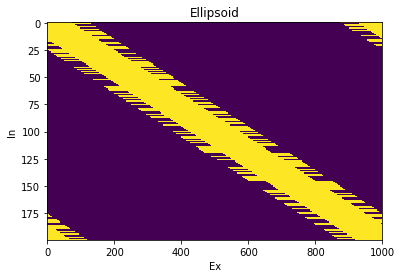

In [11]:
plt.imshow(in_ex_connectivity_ell, aspect='auto')
plt.title('Ellipsoid')
plt.xlabel('Ex')
plt.ylabel('In')

Text(0, 0.5, 'In')

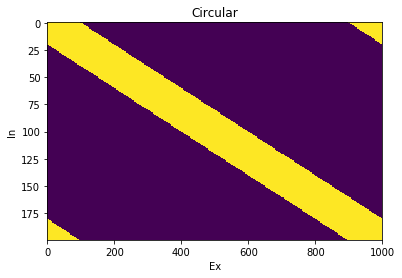

In [12]:
plt.imshow(in_ex_connectivity_circ,aspect='auto')
plt.title('Circular')
plt.xlabel('Ex')
plt.ylabel('In')

## Network activity

In [13]:
from brian2.units import *

#### Create the network

In [14]:
dynamics_dict = {
    "excitatory": {
       "model": "placeholder",
        "threshold": "v>v_threshold",
        "reset": "v=v_reset",
        "refractory": "tau_refractory"

    },
    "ex-in": {
        "model": "w: volt",
        "on_pre": "v+=w"
    }
}

model_string = """
    dv/dt = 1.0/tau* (-v + u_ext+stimulus(t,i)) :volt (unless refractory)
    tau :second
    u_ext : volt
    v_threshold: volt
    v_reset: volt
    tau_refractory: second
"""

dynamics_dict["excitatory"]["model"] =model_string
dynamics_dict.update({"inhibitory":dynamics_dict["excitatory"]})

dynamics_dict.update({"in-ex": dynamics_dict["ex-in"]})

In [15]:
experiment_dict = {
  "duration": 1000*ms,
  "excitatory": {
    "tau": 10*ms,
    "v_threshold": -40*mV,
    "v_reset": -75*mV,
    "tau_refractory": 0.0*ms,
    "u_ext": -0*mV
  },
  "inhibitory": {
    "tau": 5*ms,
    "v_threshold": -40*mV,
    "v_reset": -75*mV,
    "tau_refractory": 0.0*ms,
    "u_ext": -35*mV
      
  },
  "ex-in": {
    "w": 0.4*mV
  },
  "in-ex": {
    "w": -1*mV
  },
  "initial_condition":{
    "excitatory": {
       "v": '-75*mV+35*mV*rand()'   
    },
    "inhibitory": {
       "v": '-75*mV+35*mV*rand()'   
    }  
  }
}

In [16]:
spatio_temporal_input = {
    "excitatory": br.TimedArray(np.zeros((1,N_i))*mV, 100*ms),
    "inhibitory": br.TimedArray(np.zeros((1,N_i))*mV, 100*ms)
}

In [17]:
from interneuron_polarity.actions.simulate_network_activity import create_neuronal_populations_and_synapses, run_experiment
import brian2 as br

def run_1d_network(in_ex_connectivity, dynamics_dict, experiment_dict, spatio_temporal_input = None):
    ex_neurons, in_neurons, ie_syn, ei_syn = create_neuronal_populations_and_synapses(dynamics_dict, in_ex_connectivity)
    
    ex_neurons.v = experiment_dict["initial_condition"]["excitatory"]["v"]
    in_neurons.v = experiment_dict["initial_condition"]["inhibitory"]["v"]
    
    ex_spike_recorder = br.SpikeMonitor(source=ex_neurons)
    in_spike_recorder = br.SpikeMonitor(source=in_neurons)
    
    if spatio_temporal_input is not None:
        ex_neurons.namespace["stimulus"] =  spatio_temporal_input["excitatory"]
        in_neurons.namespace["stimulus"] =  spatio_temporal_input["inhibitory"]
        
    
    
    run_experiment(experiment_dict, ex_neurons, in_neurons, ei_syn, ie_syn, [ex_spike_recorder, in_spike_recorder])
    
    excitatory_spikes = ex_spike_recorder.spike_trains()
    inhibitory_spikes = in_spike_recorder.spike_trains()
    
    return excitatory_spikes, inhibitory_spikes
    

In [18]:
circ_ex, circ_in = run_1d_network(in_ex_connectivity_circ, dynamics_dict, experiment_dict, spatio_temporal_input)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.29s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.03s). [brian2.stateupdaters.base.method_choice]


Starting simulation at t=0. s for a duration of 1. s


WARNING    neurongroup's variable 'v' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]


1.0 (100%) simulated in 1s


In [19]:
ell_ex, ell_in = run_1d_network(in_ex_connectivity_ell, dynamics_dict, experiment_dict, spatio_temporal_input)

INFO       No numerical integration method specified for group 'neurongroup_2', using method 'exact' (took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_3', using method 'exact' (took 0.04s). [brian2.stateupdaters.base.method_choice]


Starting simulation at t=0. s for a duration of 1. s


WARNING    neurongroup_2's variable 'v' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]


1.0 (100%) simulated in 1s


## Analyze activity

### Raster plots

In [20]:
from interneuron_polarity.actions.plot_network_activity import plot_spiking

#### Early

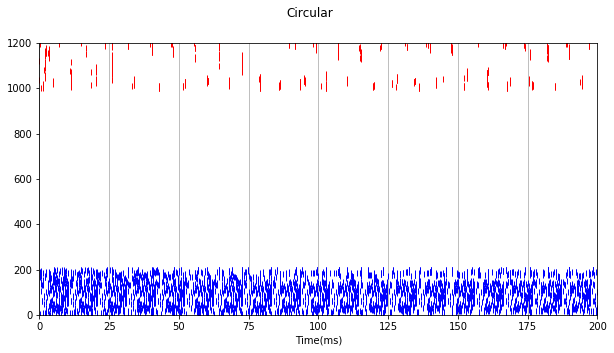

In [21]:
fig=plot_spiking(N_e, N_i, circ_ex, circ_in, t_start=0, t_end=200)
_=fig.suptitle('Circular')

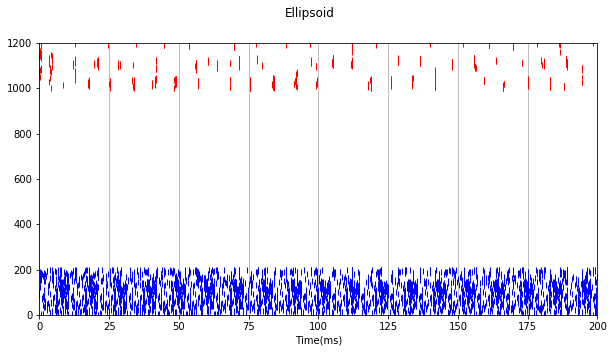

In [22]:
fig=plot_spiking(N_e, N_i, ell_ex, ell_in, t_start=0, t_end=200)
_=fig.suptitle('Ellipsoid')

#### Late

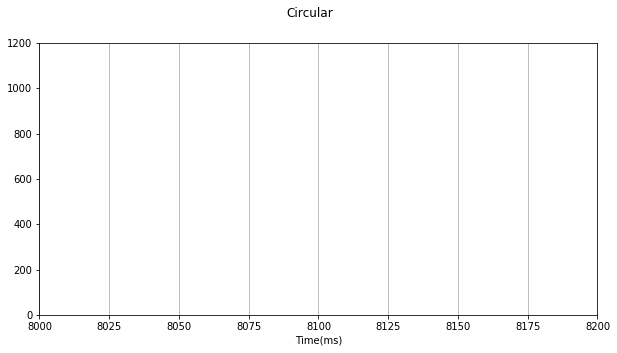

In [23]:
fig=plot_spiking(N_e, N_i, circ_ex, circ_in, t_start=8000, t_end=8200)
_=fig.suptitle('Circular')

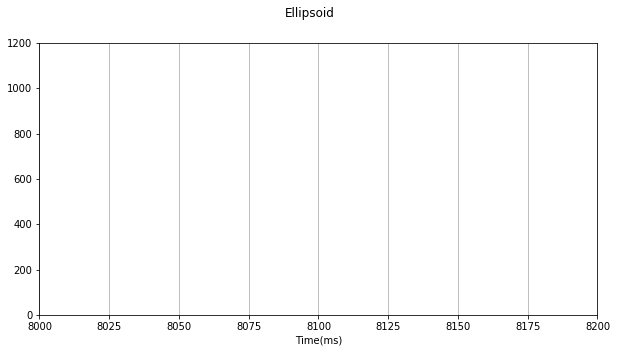

In [24]:
fig=plot_spiking(N_e, N_i, ell_ex, ell_in, t_start=8000, t_end=8200)
_=fig.suptitle('Ellipsoid')

### Rate distribution in space

In [25]:
from matplotlib.gridspec import GridSpec

In [26]:
def isi_to_rate(isi):
    rate = 1.0/isi
    rate[np.where(isi==0)] = 0*hertz
    return rate

WARNING    /home/pfeiffer/Applications/miniconda2/envs/interneuron_polarity/lib/python3.7/site-packages/brian2/units/fundamentalunits.py:227: RuntimeWarning: Mean of empty slice.
  return Quantity(func(np.array(x, copy=False), *args, **kwds), dim=x.dim)
 [py.warnings]
WARNING    /home/pfeiffer/Applications/miniconda2/envs/interneuron_polarity/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]


(0, 500)

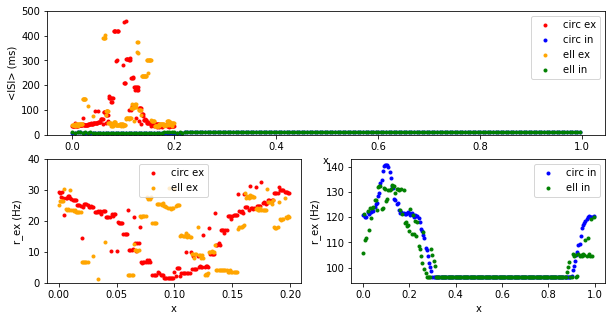

In [27]:
fig = plt.figure(figsize=(10,5))

grid = GridSpec(2,2)
ax = fig.add_subplot(grid[0,:])
ax_ex = fig.add_subplot(grid[1,0])
ax_in = fig.add_subplot(grid[1,1])

spike_times = circ_ex
positions = ex_positions
label='circ ex'
color='red'


isis =  [np.ediff1d(spike_times[neuron_idx]) for neuron_idx in sorted(spike_times.keys())]
mean_isi =[np.mean(isi) for isi in isis]
ax.plot(positions, mean_isi/ms, '.', color=color, label=label)
ax_ex.plot(positions, isi_to_rate(np.array(mean_isi))/hertz,'.', color=color, label=label )

spike_times = circ_in
positions = in_positions
label='circ in'
color='blue'

isis =  [np.ediff1d(spike_times[neuron_idx]) for neuron_idx in sorted(spike_times.keys())]
mean_isi =[np.mean(isi) for isi in isis]
ax.plot(positions, mean_isi/ms, '.', color=color, label=label)
ax_in.plot(positions, isi_to_rate(np.array(mean_isi))/hertz,'.', color=color, label=label )


spike_times = ell_ex
positions = ex_positions
label='ell ex'
color='orange'

isis =  [np.ediff1d(spike_times[neuron_idx]) for neuron_idx in sorted(spike_times.keys())]
mean_isi =[np.mean(isi) for isi in isis]
ax.plot(positions, mean_isi/ms, '.', color=color, label=label)
ax_ex.plot(positions, isi_to_rate(np.array(mean_isi))/hertz,'.', color=color, label=label )


spike_times = ell_in
positions = in_positions
label='ell in'
color='green'

isis =  [np.ediff1d(spike_times[neuron_idx]) for neuron_idx in sorted(spike_times.keys())]
mean_isi =[np.mean(isi) for isi in isis]
ax.plot(positions, mean_isi/ms, '.', color=color, label=label)
ax_in.plot(positions, isi_to_rate(np.array(mean_isi))/hertz,'.', color=color, label=label )


ax_ex.set_xlabel('x')
ax_ex.set_ylabel('r_ex (Hz)')
ax_ex.legend()
ax_ex.set_ylim(0,40)
ax_in.set_xlabel('x')
ax_in.set_ylabel('r_ex (Hz)')
ax_in.legend()


ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('<ISI> (ms)')

ax.set_ylim(0,500)



#### Distribution of inhibitory input in space

The ellipsoid axons generate a spatially heterogeneous input, that produce the ups and downs of the excitatory firing rates. The inhibitory axons mimic this, but depending on their orientation, they are a right shifted, respectively left shifted version of the excitatory profile.

Text(0, 0.5, 'Number of inhibitory inputs')

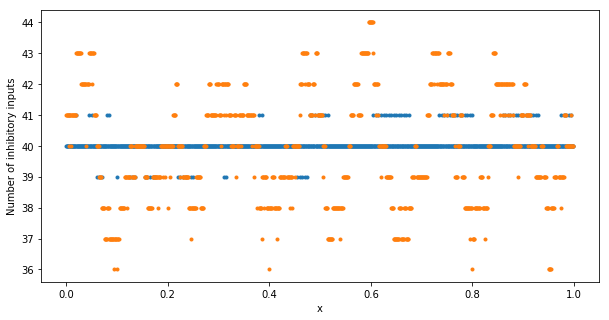

In [28]:
fig = plt.figure(figsize=(10,5))

ax= fig.add_subplot(111)

ax.plot(ex_positions, np.sum(in_ex_connectivity_circ, axis=0), '.')
ax.plot(ex_positions, np.sum(in_ex_connectivity_ell, axis=0), '.')
ax.set_xlabel("x")
ax.set_ylabel("Number of inhibitory inputs")

## Spike counts

In [29]:
from interneuron_polarity.analysis.spike_trains import spikecounts


In [30]:
dt = 50*ms
t_start = 0*ms
t_end = 10000*ms
times = np.arange(t_start, t_end+dt, dt)*second -t_start


circ_ex_counts = spikecounts(circ_ex, dt, t_start, t_end)
circ_in_counts = spikecounts(circ_in, dt, t_start, t_end)

ell_ex_counts = spikecounts(ell_ex, dt, t_start, t_end)
ell_in_counts = spikecounts(ell_in, dt, t_start, t_end)

### Rates in space and time

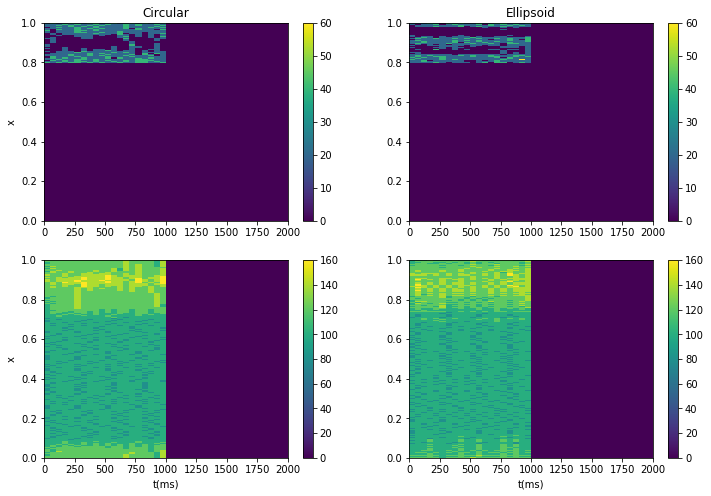

In [31]:
fig = plt.figure(figsize=(12,8))

grid = GridSpec(2,2)

ax_circ_ex = fig.add_subplot(grid[0,0])
ax_circ_in = fig.add_subplot(grid[1,0])

ax_ell_ex = fig.add_subplot(grid[0,1])
ax_ell_in = fig.add_subplot(grid[1,1])

min_idx = 0 
max_idx = 40
im = ax_circ_ex.imshow(circ_ex_counts[:, min_idx:max_idx]/dt/hertz, aspect='auto', extent=(times[min_idx]/ms, times[max_idx]/ms, 0,1))
fig.colorbar(im, ax=ax_circ_ex)

im = ax_circ_in.imshow(circ_in_counts[:, min_idx:max_idx]/dt/hertz, aspect='auto', extent=(times[min_idx]/ms, times[max_idx]/ms, 0,1))
fig.colorbar(im, ax=ax_circ_in)

im = ax_ell_ex.imshow(ell_ex_counts[:, min_idx:max_idx]/dt/hertz, aspect='auto', extent=(times[min_idx]/ms, times[max_idx]/ms, 0,1))
fig.colorbar(im, ax=ax_ell_ex)

im = ax_ell_in.imshow(ell_in_counts[:, min_idx:max_idx]/dt/hertz, aspect='auto', extent=(times[min_idx]/ms, times[max_idx]/ms, 0,1))
fig.colorbar(im, ax=ax_ell_in)




ax_circ_ex.set_ylabel("x")
ax_circ_in.set_ylabel("x")

ax_circ_in.set_xlabel("t(ms)")
ax_ell_in.set_xlabel("t(ms)")

ax_circ_ex.title.set_text('Circular')
ax_ell_ex.title.set_text('Ellipsoid')

### Spatial frequencies

#### Spectral analysis with unequally sampled data

https://joseph-long.com/writing/recovering-signals-from-unevenly-sampled-data/

Here is how to get the phase as well https://stackoverflow.com/questions/49859075/lomb-scargle-phase

A better lomb scargle from astropy https://docs.astropy.org/en/stable/timeseries/lombscargle.html

In [32]:
import scipy.signal as scs

In [33]:
def get_spatial_periodogram(positions, spikecounts, spatial_frequencies):
    powers = [scs.lombscargle(positions, count, 2*np.pi*spatial_frequencies, precenter=True) for count in spikecounts.T]
    return np.vstack(powers).T
        
    

In [34]:
spatial_frequencies = np.arange(0.1,40,0.1)

In [35]:
circ_ex_spatial_powers = get_spatial_periodogram(ex_positions, circ_ex_counts, spatial_frequencies)
ell_ex_spatial_powers = get_spatial_periodogram(ex_positions, ell_ex_counts, spatial_frequencies)

In [36]:
random_power = scs.lombscargle(ex_positions, np.random.randint(np.min(circ_ex_counts),np.max(circ_ex_counts), ex_positions.shape[0]), 2*np.pi*spatial_frequencies, precenter=True)

Text(0, 0.5, 'Power (a.u.)')

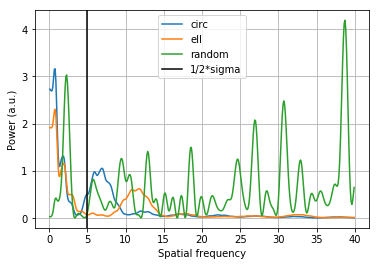

In [37]:
plt.plot(spatial_frequencies, np.mean(circ_ex_spatial_powers, axis=1), label='circ')
plt.plot(spatial_frequencies, np.mean(ell_ex_spatial_powers, axis=1), label='ell')

plt.plot(spatial_frequencies, random_power, label='random')
plt.axvline(1.0/(2*sigma), color='k', label="1/2*sigma")
plt.legend()
plt.grid()

plt.xlabel("Spatial frequency")
plt.ylabel("Power (a.u.)")

In [38]:
circ_in_spatial_powers = get_spatial_periodogram(in_positions, circ_in_counts, spatial_frequencies)
ell_in_spatial_powers = get_spatial_periodogram(in_positions, ell_in_counts, spatial_frequencies)

In [39]:
random_power = scs.lombscargle(ex_positions, np.random.randint(np.min(circ_in_counts),np.max(circ_in_counts), ex_positions.shape[0]), 2*np.pi*spatial_frequencies, precenter=True)

Text(0, 0.5, 'Power (a.u.)')

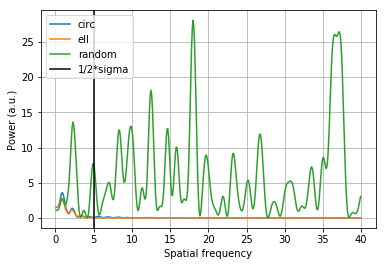

In [40]:
plt.plot(spatial_frequencies, np.mean(circ_in_spatial_powers, axis=1), label='circ')
plt.plot(spatial_frequencies, np.mean(ell_in_spatial_powers, axis=1), label='ell')

plt.plot(spatial_frequencies, random_power, label='random')
plt.axvline(1.0/(2*sigma), color='k', label="1/2*sigma")
plt.legend()
plt.grid()

plt.xlabel("Spatial frequency")
plt.ylabel("Power (a.u.)")

## Intermediate summary

- Rosenbaum shows that in a spatial network with no recurrent connectivity there is no dynamic balance possible
- their results indicate that instead certain fourier modes stabilize so that the system has a spatial output profile
- although they have a more complicated connectivity rule, I tried to reproduce the periodicty in the spiking output
- my idea was to contrast this periodicity with spatial profiles in the case of ellipsoid axons
- my spatial analysis indicates spatial periodicity in the circular case (double check), however it is not stable and moves across the tissue
- with the 1d analogue of the ellipsoids this spatial profile dissolves and new spatial heterogeneity emerges, because inhibition is distributed in a non-uniform way
- I think the spatial periodicity only comes in when inhibition is strong enough to bring the excitatory neurons below threshold, it requires the non-linearity of the excitatory neurons
- in the same way that asymmeric (ellipdoid) connections affect the spatial periodicity, so does noise in the neuronal positions
- a network with ellipsoid axons that all show in the same direction preserves the spatial periodicity


#### Questions
- what about noisy input, mimic Rosenbaum setup with spatially shared input noise
- look at correlations where mean firing is substracted
- better understanding of the necessary input strengths and synaptic weights
- could one study the asymmetry alone by generating two inhibitory populations one with right directionality and with left directionality? how would such a network behave?

#### Notes on input strength
- when total excitatory drive > inhibitory drive (that is E fire more often than I) , then spatial differences stem from the unequal distribution of inhibition
experiment_dict = {
  "duration": 10000*ms,
  "excitatory": {
    "tau": 10*ms,
    "v_threshold": -40*mV,
    "v_reset": -75*mV,
    "tau_refractory": 0.0*ms,
    "u_ext": 0*mV
  },
  "inhibitory": {
    "tau": 5*ms,
    "v_threshold": -40*mV,
    "v_reset": -75*mV,
    "tau_refractory": 0.0*ms,
    "u_ext": -41*mV
      
  },
  "ex-in": {
    "w": 0.05*mV
  },
  "in-ex": {
    "w": -0.4*mV
  },
  "initial_condition":{
    "excitatory": {
       "v": '-75*mV+35*mV*rand()'   
    },
    "inhibitory": {
       "v": '-75*mV+35*mV*rand()'   
    }  
  }
}

- but this behaviour persists even when E fire less often than I 
- more important seems to be, to be in the non-linear regime, where ensembles of excitatory neurons can silence other ensembles
experiment_dict = {
  "duration": 10000*ms,
  "excitatory": {
    "tau": 10*ms,
    "v_threshold": -40*mV,
    "v_reset": -75*mV,
    "tau_refractory": 0.0*ms,
    "u_ext": -0*mV
  },
  "inhibitory": {
    "tau": 5*ms,
    "v_threshold": -40*mV,
    "v_reset": -75*mV,
    "tau_refractory": 0.0*ms,
    "u_ext": -35*mV
      
  },
  "ex-in": {
    "w": 0.4*mV
  },
  "in-ex": {
    "w": -1*mV
  },
  "initial_condition":{
    "excitatory": {
       "v": '-75*mV+35*mV*rand()'   
    },
    "inhibitory": {
       "v": '-75*mV+35*mV*rand()'   
    }  
  }
}

### Questions to Farzada
- how well do you think this provides an analogue of the 3d case? how well do these findings apply to the 3d case?
- how can I characterise the network? what input strengths and synaptic weights have to be tested for? 
- do you think that this is an interesting network to start with in the circular case?


### What is the purpose of the model? 

The experimental finding of this unusual axonal morphology (and the non-trivial connectivity rule) stands in contrast to the usual belief of the homogeneous blanket of inhibition. So the model should adress the question how the unusual morphology affects current believes about the role of interneurons and the way they shape network activity.

So I should read up some Yuste work to see how they connect the blanket of inhibition hypothesis with dynamics of networks and the functional role of interneurons.

I still require a starting point, so ideally the network with a spherical axon morphology generating some known and relevant dynamics. Then I could study how deviations in the morphology affect this dynamics. 

Possible starting points are
- head direction tuning by recurrent inhibition
- the shepston paper about the subiculum
- the yuste paper about the blanket of inhibition hypothesis
- the rosenbaum paper about the effect of spatially structured connectivity on network dynamics especially dynamically balanced states

The first seemed to be hard to connect, because these networks mostly live in feature space and it is not clear how their connectivity fits to the spatial connectivity rules that we had found. However, rethinking what I observed so far, maybe one could use the directionality of the asymmetric neurons to build structurally similar networks, but this is not possible with the symmetric ones in the circular case.

The second and third, I still need to read.

The Rosenbaum paper start at least from a very similar perspective, they look at states a network can be in for given spatial connectivity rules. Their setup is slightly more complex, but it seems to be a valid question to see whether their analysis applies to our network as well. What could be the function? Can I go back to a balanced state with inhibitory axons that distribute inhibition more broadly? Probably not, because their is no recurrent excitation. 



### 2019-08-26 Discussion with Farzada

- she pointed out that spatial heterogeneity can also be generated by changing the positions of the inhibitory neurons in a random fashion, actually  I's that just change position in a random fashion with a small jump to the left and right generate exactly the same network connectivity, however the distance-connectivity relation would be like in the circular case, in a way this means that for 1d connectivity, at least if propagation time is not included, the ellipsoid connectivity can also be generated from circular connectivities, does this also hold for 2d? another way to break this simple way of mimicking the ellipsoid heterogenity by moving the interneurons is to provide input that has a location, because then in the ellipsoid case, two Is that project to the same E might have very different input, but in the circular-position distorted way will have the same input, this means if I start out with a network that has positional changes and one that has ellipsoids I would see differences in the way that they react to localised input
- why are their this travelling waves and how do they move? This did not become entirely clear to me, she suggested using localised pertubations to study this propagation



## 2019-08-26 Yangfan 

### Correlation input strength and activity
- alle bekommen denselben Inputs, allerdings bei spatially localised input (subselection of synapses or up and downscaling or regulation of excitability)
- wie sieht das in 3d aus...?
- r_ex gegen number of inhibitory inputs?

- unser wichtigere point, pyramiden-pyramiden activity, was passiert wenn man ein ensemble aktiviert...
- was ist spatially tuned input, extremely suppressed when the neuron does not fit with the direction
- was bringt es, dass sich die Pyramidalneurone nicht gegenseitig erregen, sondern nur hemmen
### Rosenbaum
- inwiefern kann unser Netzwerk überhaupt filtern, paragraph in den discussions...

### Echte Head Direction cells in the presubiculum
- very different peak firing rates, from 20 to 100Hz
- signal to noise ratio that goes up to 1000
- 


## 2019-08-27 some more thoughts
- how does a recurrent connection come about? what synaptic plasticity rule can generate this?


# Localised input

- use TimedArray to allow for temporally and spatially modulated input
- can this be part of the parameters via the namespaces of the neurongroups, https://brian2.readthedocs.io/en/2.0rc/advanced/namespaces.html


In [41]:
import math

In [100]:
t_start = 50*ms
t_end = 150*ms

def get_spatial_stimulus(spatial_shape, neuron_positions, t_start, t_end):
    number_of_neurons = len(neuron_positions)
    
    dt= math.gcd(int(t_start/ms), int((t_end-t_start)/ms))*ms
    stimuli = spatial_shape(neuron_positions)
    
    unit = stimuli[0]/br.asarray(stimuli[0])
    before_onset = np.zeros((int(t_start/dt), number_of_neurons))
    during_pulse = np.repeat(np.expand_dims(stimuli, 1).T, (t_end-t_start)/dt, axis=0)
    
    return br.TimedArray(np.vstack([before_onset, during_pulse, before_onset ])*unit, dt=dt)

In [101]:
spatial_profile = lambda x: 30*np.exp(-(x-0.5)**2/2.0/(0.07)**2)*mV

In [102]:
spatial_stimulus = get_spatial_stimulus(spatial_profile, ex_positions, t_start, t_end)

In [103]:
spatio_temporal_input = {
    "excitatory": spatial_stimulus,
    "inhibitory": br.TimedArray(np.zeros((1,N_i))*mV, 100*ms)
}

In [104]:
circ_ex, circ_in = run_1d_network(in_ex_connectivity_circ, dynamics_dict, experiment_dict, spatio_temporal_input)

Starting simulation at t=0. s for a duration of 1. s
1.0 (100%) simulated in 1s


In [105]:
ell_ex, ell_in = run_1d_network(in_ex_connectivity_ell, dynamics_dict, experiment_dict, spatio_temporal_input)

Starting simulation at t=0. s for a duration of 1. s
1.0 (100%) simulated in 1s


## Analyze activity

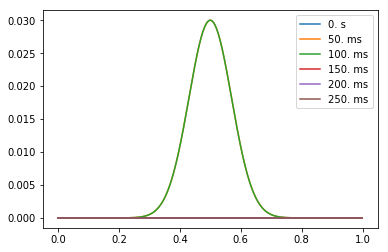

In [106]:
ts = [0*ms, 50*ms, 100*ms, 150*ms, 200*ms, 250*ms]
for t in ts:
    plt.plot(ex_positions, spatial_stimulus(t, np.arange(0,N_e,1)), label=t)
    
plt.legend()

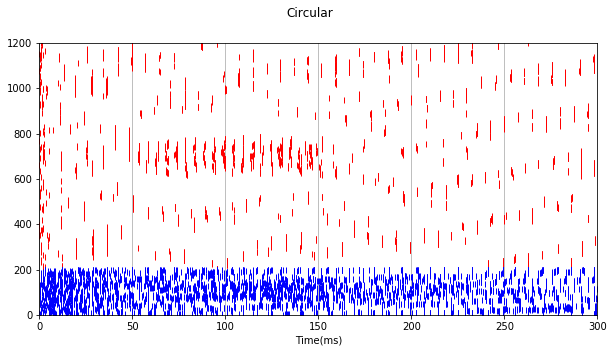

In [107]:
fig=plot_spiking(N_e, N_i, circ_ex, circ_in, t_start=0, t_end=300)
_=fig.suptitle('Circular')

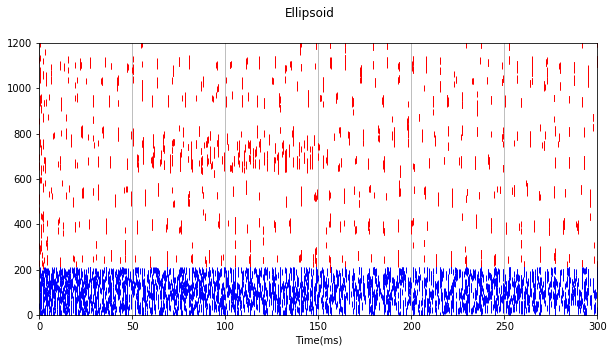

In [108]:
fig=plot_spiking(N_e, N_i, ell_ex, ell_in, t_start=0, t_end=300)
_=fig.suptitle('Ellipsoid')